## An Introduction to NetworkUnit

When considering model simulations and their evaluation, it is important
to precisely define the terminology and to be clear about the interpretation
of the results in order to judge the validity and the scope of applicability
of the model. For all practical purposes, in modeling one should be
concerned with its testable correctness relative to the given system
of interest, because only this process justifies its use as the basis
for analytic reasoning and prediction making.

In 1979 the Technical Committee on Model Credibility of the Society
of Computer Simulation established a widely recognized description
of a model verification and validation environment. We adapt this
terminology to the field of neural network modeling 
([*Trensch et al.* , 2018](#trensch2018); [*Gutzen et al.* , sub.](#gutzen2018)). 
The validation setup
is separated into three basic elements (see figure below).
The system of interest can be defined as "an entity, situation,
or system which has been selected for analysis" ([*Schlesinger et al.* ,1979.](#schlesinger1979)),
and constitutes the references against which validations are carried
out. When specifying this system of interest it is important to also
explicitly define the boundaries in which the modeling is expected
to be adequate. The modeling effort itself is separated into the definition
of the conceptual model, and its implementation as a computerized
model. The conceptual model is an abstract description formed by analysis
and observation of the system of interest. In the case of network
simulations, the conceptual model takes on the form of a mathematical
model describing the dynamics of neurons and the connectivity structure,
and other dynamic features of the simulation (e.g., inclusion of neuromodulatory
effects). An implementation of the conceptual mathematical model in
a computer software or in hardware, on the other hand, results in
a computerized, or more concretely for neural simulation, an executable
model.

The process of evaluating the degree to which the executable model is a correct
realization of the mathematical model is termed 'verification'.
In contrast, the comparison of the predictions generated by the computerized
model to the system of interest considering its intended domain of
applicability is the process called 'validation'. Together with
the process of 'confirmation', which attributes credibility to the
mathematical model as a useful description of the system of interest,
these three attributes form a circle that typically receives multiple
iterations consisting of improvements of the mathematical model and
its implementation as an executable model.

<div style='float:left; width:48%; display:inline-block'>
    <img src="../figures/validation_environment.png" width="100%" />
</div>
<div style='float:right; text-align:left; width:48%; display:inline-block'>
    <p><b>System of interest:</b> an entity, situation, or system which has been selected for analysis</p><br>
    <p><b>Mathematical model:</b> an abstract description formed by analysis and observation of the system of interest.</p><br>
    <p><b>Executable model:</b> an implementation of the mathematical model</p><br>
    <p><b>Confirmation:</b> attributing credibility to the mathematical model as a useful description of the system of interest.</p><br>
    <p><b>Verification:</b> evaluation whether the executable model is a correct realization of the mathematical model</p><br>
    <p><b>Validation:</b> a quantitative evaluation of usefulness and accuracy</p><br>
</div>

The NetworkUnit module builds upon the formalized validation scheme of the [SciUnit](https://github.com/scidash/sciunit) package, 
which enables the validation of *model*s against experimental data (or other models) via *tests*.
A test is matched to the model by *capabilities* and quantitatively evaluated by a *score*.
The following figure illustrates a typical test design within NetworkUnit. 
The blue boxes indicate the components of the implementation of the validation test, i.e., 
classes, class instances, data sets, and parameters. 
The relation between the boxes are indicated by annotated arrows.The basic functionality is 
shown by green arrows.  The difference in the test design for comparing against experimental 
data (validation) and  another  simulation  (substantiation)  is  indicated  by  yellow  and  
red  arrows,  respectively.  The  relevant  functionality  of  some  components  for  the  
computation  of  test  score  is  indicated  by  pseudo-code.  The  capability  
class `ProducesProperty` contains  the  function `calc_property()`. The test `XYTest` has a function 
`generate_prediction()` which makes use of this capability, inherited by the model class, 
to generate a model prediction. The initialized test instance `XYTest_paramZ` makes use of its 
`judge()` function to evaluate this model prediction and compute the score `TestScore`. 
The `XYTest` can inherit from multiple abstract test classes (`BaseTest`), 
which is for example used with the `M2MTest` to add the functionality of evaluating multiple model classes. 
To make the test executable it has to be linked to a ScoreType and all free parameters need to be set 
(by a `Params` dict) to ensure a reproducible result.

<div style='width:50%; display:block; margin-left:auto; margin-right:auto'>
        <img src="../figures/NetworkUnit_Flowchart_X2M_M2M.png" width="100%" />
</div>

So far, we considered a scenario in which a model is compared to experimental
observations. However, there are circumstances in which a model is
the object of reference. This model could be another implementation
of the model under scrutiny, an alternative model, or a different
simulation run of the same model. In the following, we explore such
validation scenarios, which we collectively term *model-to-model
validation*. When using NetworkUnit every test comparing model to 
experiment (`example_test`) can be transformed to a test comparing 
two (or more) models by inheritence of the `M2MTest` class.

`class example_test_M2M(sciunit.TestM2M, example_test):`

One possible scenario is the need to demonstrate the
equivalence of alternative implementations of the same model. These
implementations could, for example, be realized by different simulation
engines, like in our first example by a C simulation and a simulation on the SpiNNaker hardware.

In [1]:
%matplotlib inline
import sys
import sciunit
import numpy as np
import neo
import quantities as pq
from networkunit import models, tests, scores, plots, capabilities
from copy import copy  
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks')
import warnings
warnings.filterwarnings('ignore')

/home/rgutzen/anaconda3/envs/networkunit/lib/python3.8/site-packages/elephant/parallel/__init__.py:47: UserWarning: mpi4py package is missing. Please run 'pip install mpi4py' in a terminal to activate MPI features.
  warnings.warn("mpi4py package is missing. Please run 'pip install mpi4py' "


The model classes can either be run a simulation or load data from a file. Here, for example purposes we use stochastically generated data, generated by the `stochastic_activity` model class.

In [2]:
model_A = models.stochastic_activity('model A', 
                                     size=100, 
                                     t_start=0*pq.ms,
                                     t_stop=10000*pq.ms,
                                     rate=10*pq.Hz,
                                     correlation_method='CPP',
                                     assembly_size=[10],
                                     correlations=[.4],
                                     color='#2173a3')

To modify existing models, you can also define corresponding child classes.

In [3]:
class new_model(models.stochastic_activity):
    default_params = {**models.stochastic_activity.default_params}
    default_params.update(size=100, 
                          t_start=0*pq.ms,
                          t_stop=60000*pq.ms,
                          rate=10*pq.Hz,
                          correlation_method='CPP',
                          assembly_size=[10],
                          correlations=[.4])
    
# see model class definition for more options

In [4]:
model_A = new_model('model A',
                    color='#2173a3')

model_B = new_model('model B',
                    rate=11*pq.Hz,
                    correlation_method='spatio-temporal',
                    max_pattern_length=100*pq.ms,
                    color='#77b74a')

#### Show the spiking activity data

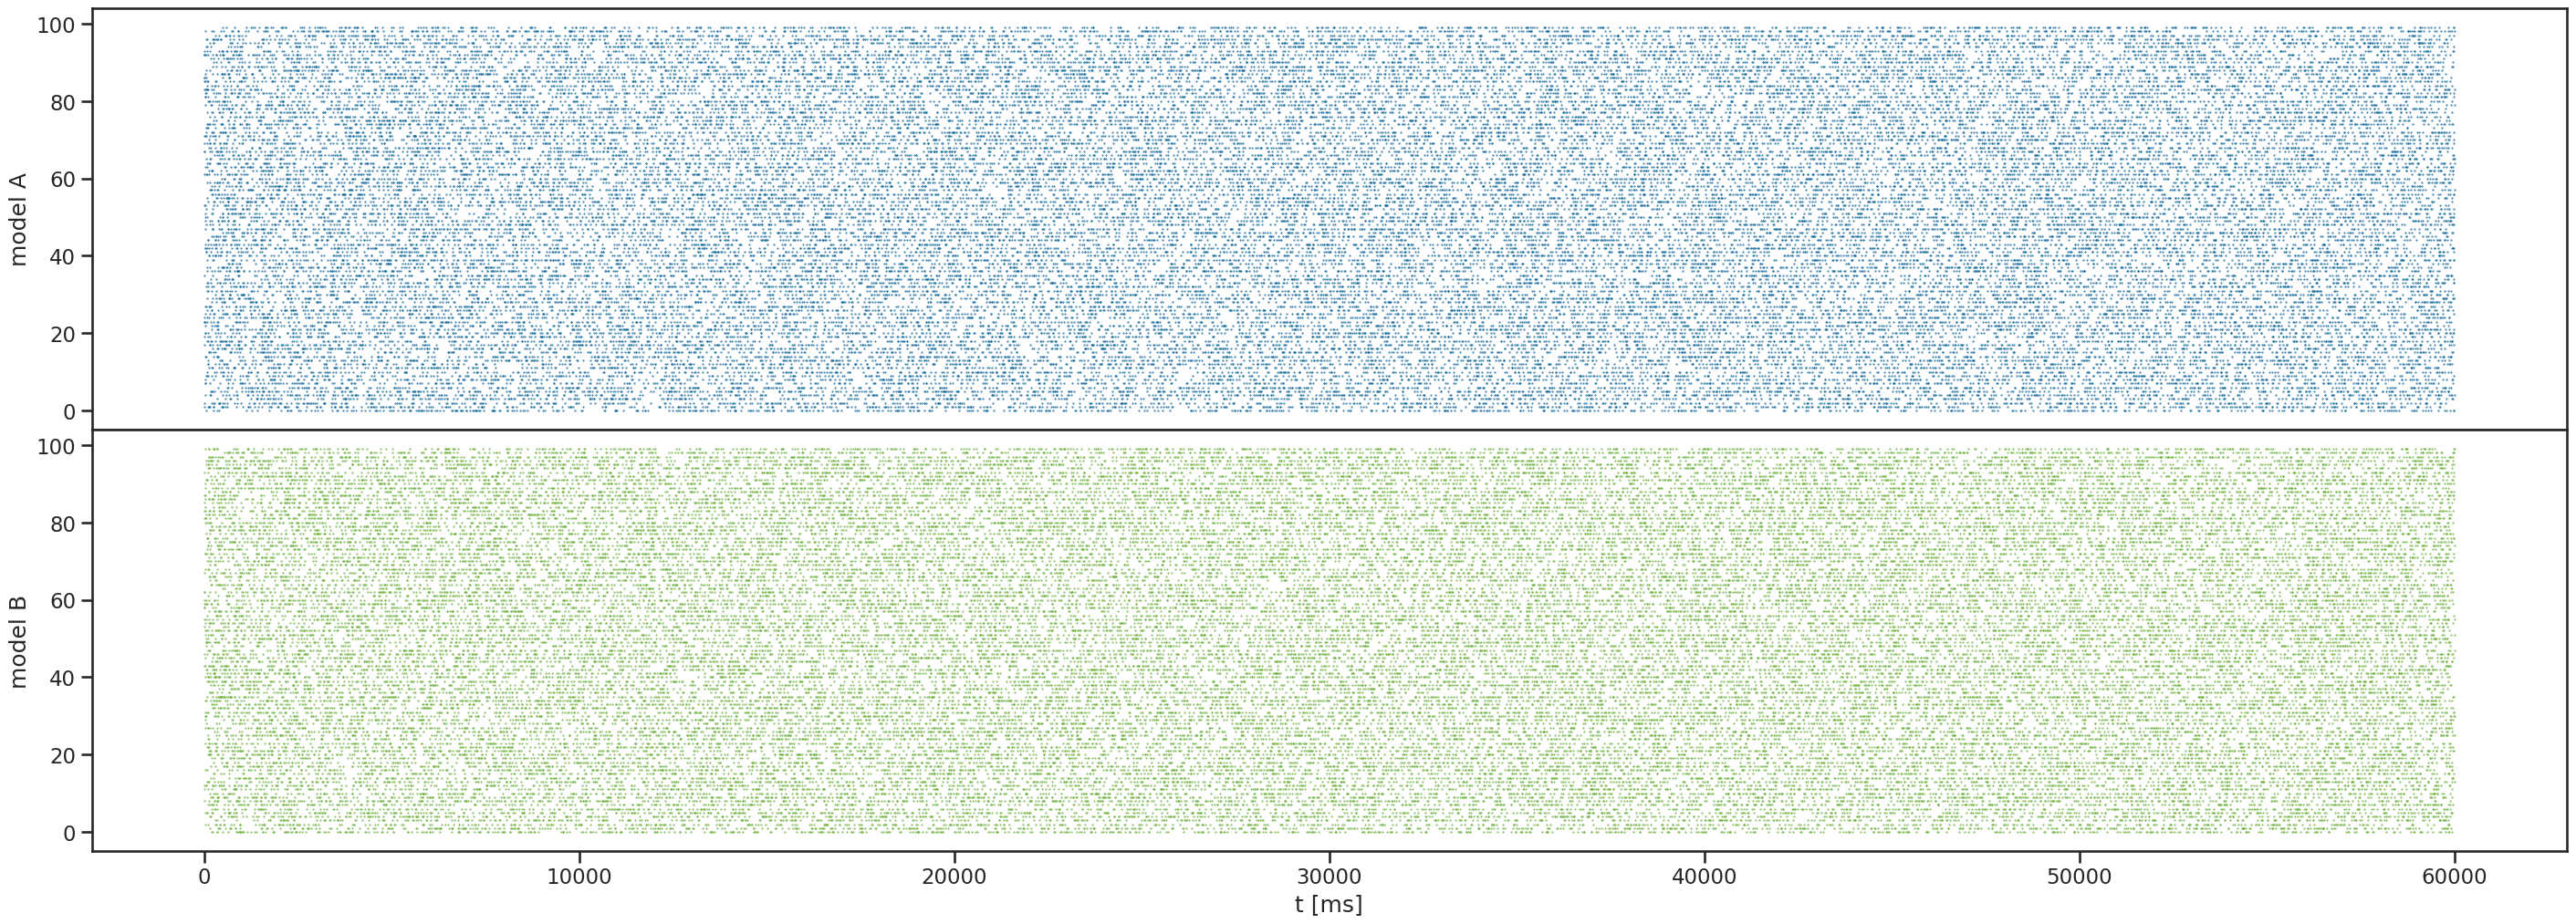

In [5]:
fig, ax = plt.subplots(nrows=2, sharex=True, 
                       gridspec_kw={'hspace':0}, 
                       figsize=(35,12))

for i, model in enumerate([model_A, model_B]):
    for st_count, st in enumerate(model.produce_spiketrains()):
        ax[i].plot(st, [st_count]*len(st), 
                   color=model.params['color'], marker='.', markersize=1.,
                   linestyle="None")
    ax[i].set_ylabel(model.name)
ax[-1].set_xlabel('t [ms]');

#### Test definitons
The validation tests are also defined as classes. NetworkUnit offers a variety of base tests from which tests can be derived.

In [6]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.effect_size
    
class LV_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'lv'}
    
FR_test = FR_test_class()
LV_test = LV_test_class()

#### What can tests do?
... every test has a function generate_prediction() which calculates the test measure

In [7]:
FR_test.generate_prediction(model_A);

#### What can tests do?
... the test classes are also able to visualize the the generated samples.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


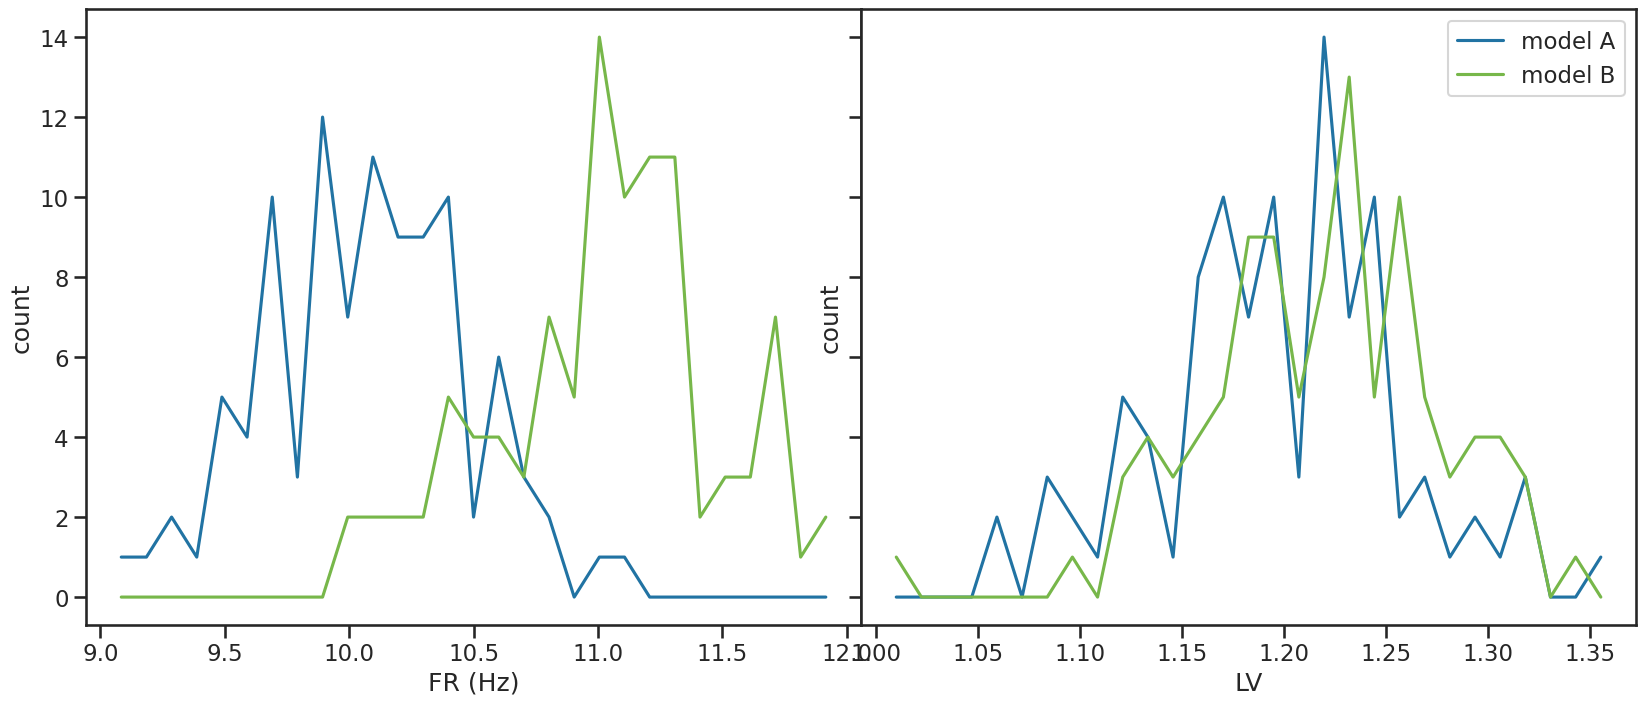

In [8]:
fig, ax = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0}, figsize=(20,8))

FR_test.visualize_samples(model_A, model_B, ax=ax[0], var_name='FR (Hz)', bins=30, density=False)
LV_test.visualize_samples(model_A, model_B,  ax=ax[1], var_name='LV', bins=30, density=False);

#### What can tests do? 
... to perform the actual validation and calculate a test score, you call the judge() function, which will
    1. check if the model has all the required capabilities.
    2. call generate_prediction()
    3. call compute_score()
    4. check that the score is of score_type
    5. equip the score with metadata
    6. returns the score.

In [9]:
# For a model-to-model test the two models are passed as a list
print('FR test:\n', FR_test.judge([model_A, model_B]).score)

FR test:
           model A   model B
model A  0.000000  2.270147
model B  2.270147  0.000000


In [10]:
# to access an element of the score DataFrame use
print('FR-Test ', FR_test.judge([model_A, model_B]).iloc[1,0])
print('LV-Test ', LV_test.judge([model_A, model_B]).iloc[1,0])
# print of a score instance invokes the __str__ property of the test

FR-Test  

Effect Size
	datasize: 100 	 100
	Effect Size = 2.270 	 CI = (1.914, 2.626)


LV-Test  

Effect Size
	datasize: 100 	 100
	Effect Size = 0.364 	 CI = (0.085, 0.644)




#### Using a different statistical test as score type is as simple as

In [11]:
class FR_ks_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.ks_distance # students_t, kl_divergence, mwu_statistic, best_effect_size, LeveneScore

FR_ks_test = FR_ks_test_class()

print(FR_ks_test.judge([model_A, model_B]).iloc[1,0])



Kolmogorov-Smirnov-Distance
	datasize: 100 	 100
	D_KS = 0.730 	 p value = 4.33e-26




### That's all good and fine but what about experimental data?

Whether the spiketrains data is from a simulation or an experiment, it can be handled equivalently by loading it into a model class. For this, the base class `loaded_spiketrains` needs to be equipped with a `load()` function that can load the type of file that your data is in.

Let's use the data from model_A as dummy data, and assume it comes from some experiment.

In [14]:
block = neo.Block()
block.segments = [neo.Segment()]
block.segments[0].spiketrains = model_A.spiketrains

nio = neo.io.PickleIO('temp_spiketrains.pkl')
nio.write(block)

In [17]:
class experimental_data(models.loaded_spiketrains, capabilities.ProducesSpikeTrains):
    """
    A model class to load spiking data from file.
    """

    def load(self):
        file_path = self.params['file_path']
        if file_path is None:
            raise ValueError('"file_path" parameter is not set!')

        neo.io.PickleIO(str(file_path))
        block = nio.read_block()

        spiketrains = block.list_children_by_class(neo.SpikeTrain)
        
        return spiketrains

In [18]:
data_model = experimental_data(file_path='temp_spiketrains.pkl')

data_model.produce_spiketrains()

[SpikeTrain containing 595 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms to 60000.0 ms,
 SpikeTrain containing 625 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms to 60000.0 ms,
 SpikeTrain containing 599 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms to 60000.0 ms,
 SpikeTrain containing 602 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms to 60000.0 ms,
 SpikeTrain containing 604 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms to 60000.0 ms,
 SpikeTrain containing 668 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms to 60000.0 ms,
 SpikeTrain containing 596 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms to 60000.0 ms,
 SpikeTrain containing 578 spikes; units ms; datatype float64 
 annotations: {'Model': 'model A'}
 time: 0.0 ms

### Conclusion

#### Validation testing on the level of network activity is a useful apprach (complementary to single-cell validation) to evaluate network models

#### NetworkUnit can be used to quantify the statistical difference between models and experimental data sets

#### Validation testing is applicable for 
- a) comparing model predictions to experimental findings, 
- b) guiding the model development, 
- c) checking for consistency within or across models (or data sets).

<p><i>"A model, like a novel, may resonate with nature, but it is not a 'real' thing. Like novel, a model may be convinving - it may 'ring true' if it is consistent with our experience of the natural world. But just as we may wonder how much the characters in a novel are drawn from real life and how much is artifice, we might ask the same of a model: How much is based on observation and measurement of accesssible phenomena, how much is based on informed judgment, and how much is convencience?"</i></p>
<p style="float:right">Orsekes, 1994</p>


### References

- Trensch et al. (2018)  Rigorous neural network simulations: model cross-validation665for boosting the correctness of simulation results, Frontiers in Neuroinformatics 12:81, doi: 10.3389/fninf.2018.00081 <a id='trensch2018'></a>

- Gutzen et al. (2018) Reproducible neural network simulations: model validation on the level of network activity data, Frontiers in Neuroinformatics 12:90, doi: 10.3389/fninf.2018.00090 <a id='gutzen2018'></a>

- Schlesinger, S. (1979). Terminology for model credibility, Simulation 32, 103-104. doi: 10.1177/003754977903200304<a id='schlesinger1979'></a>

